In [5]:
# Langkah 1 : Memuat dan menampilkan data
import pandas as pd

# Load the data from the uploaded Excel file
file_path = 'data.xlsx'
data_ikan = pd.read_excel(file_path)

# Display the first few rows of the dataset to understand its structure
data_ikan.head()


,ID,Jenis Ikan,Tahun,Bulan,Berat (Ton),Lokasi Penjualan,Stok Harian (Kg),Terjual Harian (Kg),Kategori Pemasaran,Status Penjualan
0,1,Udang,2022,Oktober,0.7,Aceh Utara,50,128,Jual langsung ke masyarakat,Tidak Laris
1,2,Bawal,2020,April,0.9,Aceh Utara,118,84,Suplai ke FNB atau pelaku bisnis lain,Laris
2,3,Tongkol,2022,Desember,2.7,Lhokseumawe,53,105,Penjualan langsung ke pedagang UMKM,Tidak Laris
3,4,Kerapu,2021,Juli,2.0,Lhokseumawe,65,90,Suplai ke FNB atau pelaku bisnis lain,Tidak Laris
4,5,Udang,2022,Februari,0.5,Lhokseumawe,73,64,Penjualan langsung ke pedagang UMKM,Laris


In [6]:
# Langkah 2 : Bagi Data Latioh dan Data Testing
from sklearn.model_selection import train_test_split

# Prepare the data for the decision tree model
features = data_ikan.drop(columns=['ID', 'Status Penjualan'])
labels = data_ikan['Status Penjualan']

# Convert categorical variables to numeric
features_encoded = pd.get_dummies(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_encoded, labels, test_size=0.3, random_state=42)

print("Jumlah Data Latih X : ", len(X_train),  "Jumlah Data uji X : ", len(X_test), "Jumlah Data Latih Y : ", len(y_train), "Jumlah Data Uji Y : ", len(y_test))

Jumlah Data Latih X :  70 Jumlah Data uji X :  30 Jumlah Data Latih Y :  70 Jumlah Data Uji Y :  30


In [7]:
# Langkah 3 : Melatih Fast C4.5
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Create and train the decision tree classifier
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf.fit(X_train, y_train)

# Convert feature names and class names to list
feature_names = list(features_encoded.columns)
class_names = list(clf.classes_)

# Plot the decision tree with high quality settings
plt.figure(figsize=(40,20), dpi=300)
plot_tree(clf, filled=True, feature_names=feature_names, class_names=class_names, rounded=True, precision=2, fontsize=12)
plt.tight_layout()


# Langkah 4 : Menampilkan Visualisasi Pohon Keputusan
plt.savefig('decision_tree_visualization.png', bbox_inches='tight')
plt.show()


In [9]:
# Langkah 5 : Mengekstrak atau Mengail rule dari pohon keputusan

import json
import numpy as np

# Get the tree structure
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
value = clf.tree_.value

# Function to extract rules and save to JSON
def get_rules_to_json(node=0):
    if children_left[node] != children_right[node]:  # non-leaf
        name = feature_names[feature[node]]
        threshold_value = threshold[node]
        left_rule = get_rules_to_json(children_left[node])
        right_rule = get_rules_to_json(children_right[node])
        return {
            "feature": name,
            "threshold": threshold_value,
            "left": left_rule,
            "right": right_rule
        }
    else:  # leaf
        value_counts = value[node]
        class_value = np.argmax(value_counts)
        class_name = class_names[class_value]
        return {
            "class": class_name
        }

# Extract rules and save to JSON file
rules_json = get_rules_to_json()
with open('decision_tree_rules.json', 'w') as f:
    json.dump(rules_json, f, indent=4)

# Output the paths to the saved files
output_paths = {
    'visualization': 'decision_tree_visualization.png',
    'rules': 'decision_tree_rules.json'
}

output_paths


{'visualization': 'decision_tree_visualization.png',
 'rules': 'decision_tree_rules.json'}

In [10]:

#Langkah 6 : Simpan Rule dalam bentuk .txt
import pandas as pd
import json

# Load the JSON rules
with open('decision_tree_rules.json', 'r') as f:
    rules_json = json.load(f)

# Function to classify using the rules from JSON
def classify_with_rules(rules, sample):
    if "class" in rules:
        return rules["class"]
    feature = rules["feature"]
    threshold = rules["threshold"]
    if sample[feature] <= threshold:
        return classify_with_rules(rules["left"], sample)
    else:
        return classify_with_rules(rules["right"], sample)

# Load the test data
file_path_test = 'test.xlsx'
data_test = pd.read_excel(file_path_test)

# Prepare the test data
features_test = data_test.drop(columns=['ID'])
features_encoded_test = pd.get_dummies(features_test)

# Ensure that the test data has the same columns as the training data
missing_cols = set(features_encoded.columns) - set(features_encoded_test.columns)
for c in missing_cols:
    features_encoded_test[c] = 0
features_encoded_test = features_encoded_test[features_encoded.columns]

# Classify each sample in the test data
predictions = features_encoded_test.apply(lambda x: classify_with_rules(rules_json, x), axis=1)

# Output the predictions
data_test['Predicted Status Penjualan'] = predictions
data_test.to_excel('predicted_data_test.xlsx', index=False)

predicted_data_test_path = 'predicted_data_test.xlsx'
predicted_data_test_path


'predicted_data_test.xlsx'

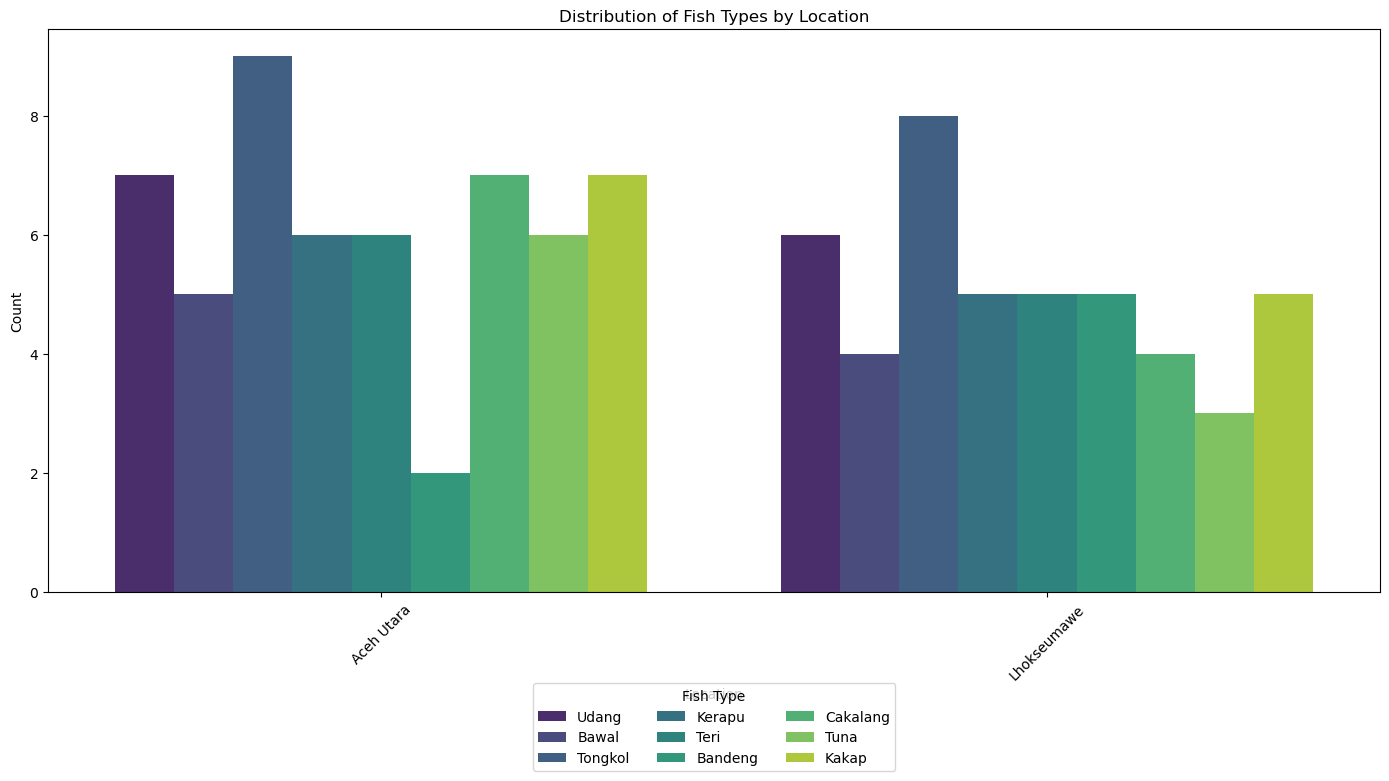

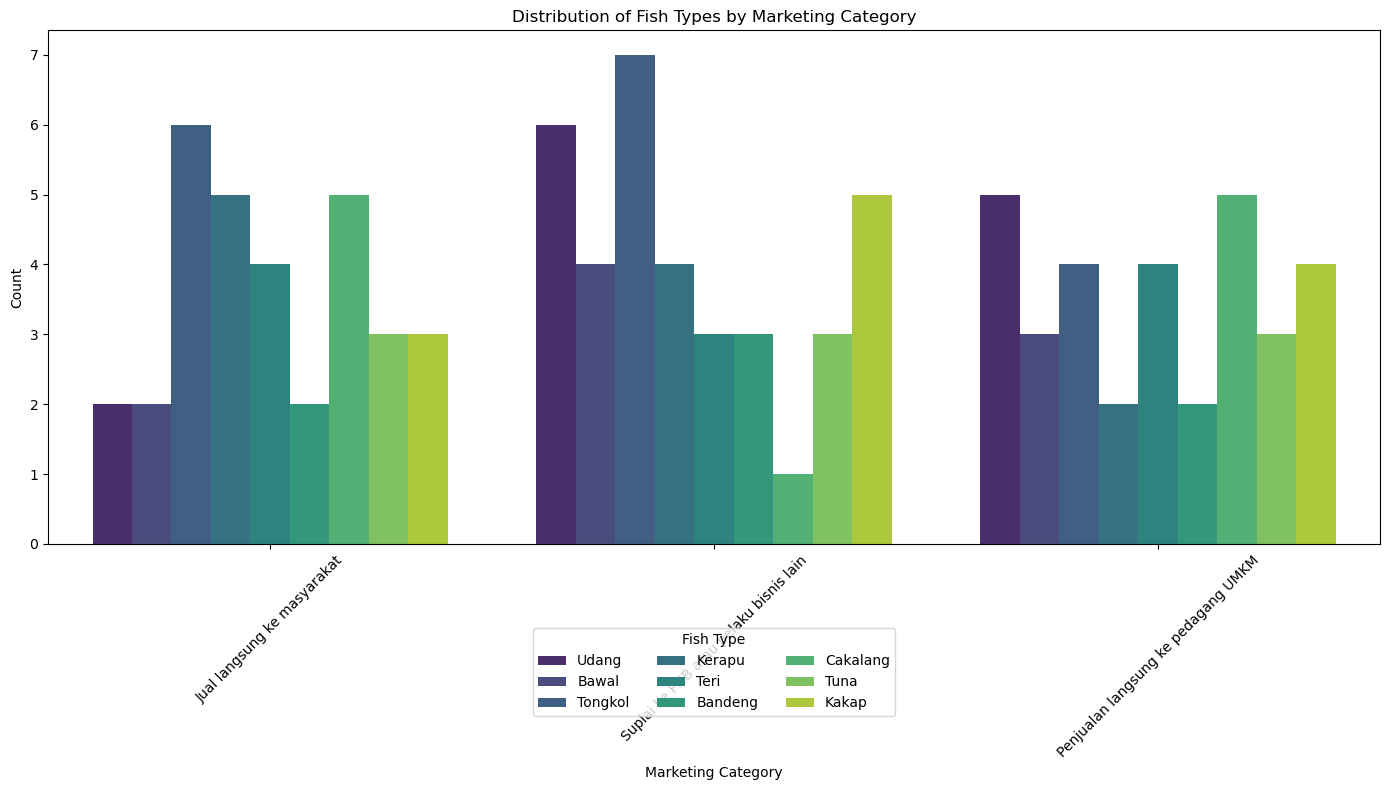

C:\Users\HP\AppData\Local\Temp\ipykernel_13728\3084754131.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')


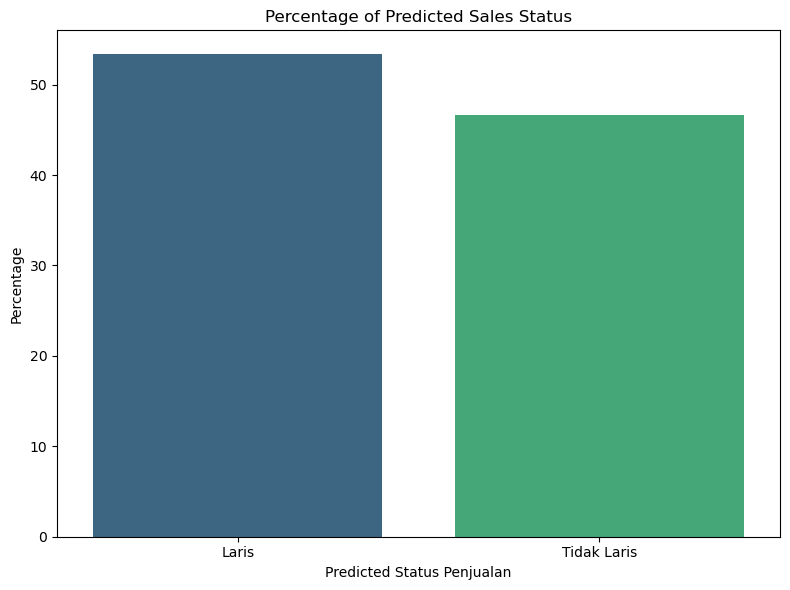

,Predicted Status Penjualan,Percentage
0,Laris,53.333333
1,Tidak Laris,46.666667


In [11]:
# Langkah 7 : Visualisasi Data
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the data based on 'Lokasi Penjualan', 'Jenis Ikan', and 'Kategori Pemasaran'

# Plot for 'Lokasi Penjualan'
plt.figure(figsize=(14, 8))
ax1 = sns.countplot(data=data_ikan, x='Lokasi Penjualan', hue='Jenis Ikan', palette='viridis')
plt.title('Distribution of Fish Types by Location')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Separate the legend and place it below the plot
legend1 = ax1.legend(title='Fish Type', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
plt.tight_layout()
plt.savefig('distribution_by_location_with_legend.png', bbox_extra_artists=(legend1,), bbox_inches='tight')
plt.show()

# Plot for 'Kategori Pemasaran'
plt.figure(figsize=(14, 8))
ax2 = sns.countplot(data=data_ikan, x='Kategori Pemasaran', hue='Jenis Ikan', palette='viridis')
plt.title('Distribution of Fish Types by Marketing Category')
plt.xlabel('Marketing Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Separate the legend and place it below the plot
legend2 = ax2.legend(title='Fish Type', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
plt.tight_layout()
plt.savefig('distribution_by_marketing_category_with_legend.png', bbox_extra_artists=(legend2,), bbox_inches='tight')
plt.show()

# Load the predicted data
predicted_data_test = pd.read_excel('predicted_data_test.xlsx')
predicted_data_test.head()

# Visualize the percentage of 'Laris' and 'Tidak Laris'
status_counts = predicted_data_test['Predicted Status Penjualan'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')
plt.title('Percentage of Predicted Sales Status')
plt.xlabel('Predicted Status Penjualan')
plt.ylabel('Percentage')
plt.tight_layout()
plt.savefig('predicted_sales_status_percentage.png')
plt.show()

# Display the table of predicted results
predicted_data_test.head()

# Display the percentage table
status_counts_df = status_counts.reset_index()
status_counts_df.columns = ['Predicted Status Penjualan', 'Percentage']
status_counts_df


In [ ]:
# Langkah 8 : Implementasi menggunakan Data Uji

# Load the predicted data
predicted_data_test = pd.read_excel('predicted_data_test.xlsx')

# Display the table of predicted results
print("Predicted Results:")
predicted_data_test

